## infcnv https://cloud.tencent.com/developer/article/1910795

In [37]:
setwd('/import/DB/zhang//data')

In [38]:
library(Seurat)
library(ggplot2)
library(clustree)
library(cowplot)
library(dplyr)

In [39]:
library(Seurat)
library(gplots)
library(ggplot2)

In [40]:
.libPaths(c('/root/miniconda3/envs/Rdoc/lib/R/library','/root/miniconda3/envs/metadoc/lib/R/library'))

In [41]:
library(copykat)

In [42]:
source('./copykat_debug.R')

In [43]:
seu.obj = readRDS('./OS.final.rds')

In [44]:
table(seu.obj$seurat_clusters)


    0     1     2     3     4     5     6     7     8     9 
10080  3392     0  2895  2606  2152     0   330   302     0 

In [45]:

    obj.counts <- as.matrix(seu.obj@assays$RNA@counts)
    
    copykat.test <- copykat(rawmat=obj.counts, 
                        id.type="S", 
                        cell.line="no", 
                        ngene.chr=5, 
                        win.size=25, 
                        KS.cut=0.15, 
                        sam.name="tissue", 
                        distance="euclidean", 
                        n.cores=60)
    pred.test <- data.frame(copykat.test$prediction)
    CNA.test <- data.frame(copykat.test$CNAmat)
    my_palette <- colorRampPalette(rev(RColorBrewer::brewer.pal(n = 3, name = "RdBu")))(n = 999)
    chr <- as.numeric(CNA.test$chrom) %% 2+1
    rbPal1 <- colorRampPalette(c('black','grey'))
    CHR <- rbPal1(2)[as.numeric(chr)]
    chr1 <- cbind(CHR,CHR)
    rbPal5 <- colorRampPalette(RColorBrewer::brewer.pal(n = 8, name = "Dark2")[2:1])
    com.preN <- pred.test$copykat.pred
    pred <- rbPal5(2)[as.numeric(factor(com.preN))]
    cells <- rbind(pred,pred)
    col_breaks = c(seq(-1,-0.4,length=50),seq(-0.4,-0.2,length=150),seq(-0.2,0.2,length=600),seq(0.2,0.4,length=150),seq(0.4, 1,length=50))
       
    pdf('figure1.pdf',height = 8,width = 8)
    heatmap.3(t(CNA.test[,4:ncol(CNA.test)]),dendrogram="r", distfun = function(x) parallelDist::parDist(x,threads =4, method = "euclidean"), 
          hclustfun = function(x) hclust(x, method="ward.D2"),
          ColSideColors=chr1,RowSideColors=cells,Colv=NA, Rowv=TRUE,
          notecol="black",col=my_palette,breaks=col_breaks, 
          keysize=1, density.info="none", trace="none",key=TRUE,
          cexRow=0.1,cexCol=0.1,cex.main=1,cex.lab=0.1,
          symm=F,symkey=F,symbreaks=T,cex=1, cex.main=4, margins=c(10,10))
    legend("topright", paste("pred.",names(table(com.preN)),sep=""), pch=15,col=RColorBrewer::brewer.pal(n = 8, name = "Dark2")[2:1], cex=0.6, bty="n")
    dev.off()
    
    
    tumor.cells <- pred.test$cell.names[which(pred.test$copykat.pred=="aneuploid")]
    tumor.cells = gsub('-','.',tumor.cells)
    tumor.mat <- CNA.test[, colnames(CNA.test) %in% tumor.cells]
    

Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 4.0 GiB"


[1] "running copykat v1.0.4"
[1] "step1: read and filter data ..."
[1] "24639 genes, 21757 cells in raw data"
[1] "10839 genes past LOW.DR filtering"
[1] "step 2: annotations gene coordinates ..."
[1] "start annotation ..."
[1] "step 3: smoothing data with dlm ..."
[1] "step 4: measuring baselines ..."
number of iterations= 282 
WARNING! NOT CONVERGENT! 
number of iterations= 5000 
number of iterations= 217 
number of iterations= 360 
number of iterations= 2492 
number of iterations= 1266 
[1] "step 5: segmentation..."
[1] "step 6: convert to genomic bins..."
[1] "step 7: adjust baseline ..."
[1] "step 8: final prediction ..."
[1] "step 9: saving results..."
[1] "step 10: ploting heatmap ..."
Time difference of 1.153037 hours


png 
  2

In [46]:
hcc <- hclust(parallelDist::parDist(t(tumor.mat),threads =4, method = "euclidean"), method = "ward.D2")
hc.umap <- cutree(hcc,3)

In [47]:
    pdf('figure2.pdf',height= 8,width = 8)
    rbPal6 <- colorRampPalette(RColorBrewer::brewer.pal(n = 8, name = "Dark2")[3:5])
    subpop <- rbPal6(2)[as.numeric(factor(hc.umap))]
    cells <- rbind(subpop,subpop)
    heatmap.3(t(tumor.mat),dendrogram="r", distfun = function(x) parallelDist::parDist(x,threads =4, method = "euclidean"), 
              hclustfun = function(x) hclust(x, method="ward.D2"),
              ColSideColors=chr1,RowSideColors=cells,Colv=NA, Rowv=TRUE,
              notecol="black",col=my_palette, key=TRUE,#breaks=col_breaks,
              keysize=1, density.info="none", trace="none",
              cexRow=0.1,cexCol=0.1,cex.main=1,cex.lab=0.1,
              symm=F,symkey=F,symbreaks=T,cex=1, cex.main=4, margins=c(10,10))
    legend("topright", c("c1","c2",'c3'), pch=15,col=RColorBrewer::brewer.pal(n = 8, name = "Dark2")[3:5], cex=0.9, bty='n')
    dev.off()

png 
  2

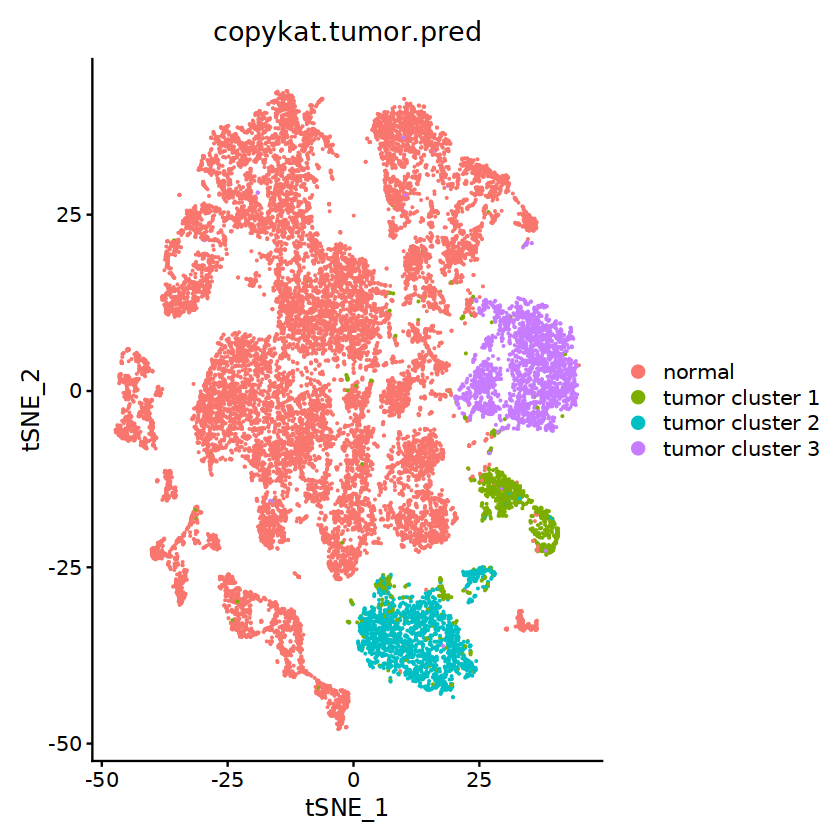

In [48]:
### back to seurat.obj
    standard10X = function(dat,nPCs=50,res=1.0,verbose=FALSE){
    srat = CreateSeuratObject(dat)
    srat = NormalizeData(srat,verbose=verbose)
    srat = ScaleData(srat,verbose=verbose)
    srat = FindVariableFeatures(srat,verbose=verbose)
    srat = RunPCA(srat,verbose=verbose)
    srat = RunTSNE(srat,dims=seq(nPCs),verbose=verbose)
    srat = FindNeighbors(srat,dims=seq(nPCs),verbose=verbose)
    srat = FindClusters(srat,res=res,verbose=verbose)
    return(srat)
    }

    tissue <- standard10X(obj.counts, nPCs=30, res=0.4)
    a = names(hc.umap)
    b = gsub('.1','-1',a)
    names(hc.umap) = b
    tissue@meta.data$copykat.tumor.pred <- rep("normal", nrow(tissue@meta.data))
    tissue@meta.data$copykat.tumor.pred[rownames(tissue@meta.data) %in% names(hc.umap[hc.umap==1])] <- "tumor cluster 1"
    tissue@meta.data$copykat.tumor.pred[rownames(tissue@meta.data) %in% names(hc.umap[hc.umap==2])] <- "tumor cluster 2"
    tissue@meta.data$copykat.tumor.pred[rownames(tissue@meta.data) %in% names(hc.umap[hc.umap==3])] <- "tumor cluster 3"

    DimPlot(tissue, group.by = "copykat.tumor.pred")
    ggsave("umap1_copykat.pdf",width =7, height = 5)
    ggsave("umap1_copykat.png",width =7, height = 5)
    saveRDS(tissue, file = "copykat_Result.rds")

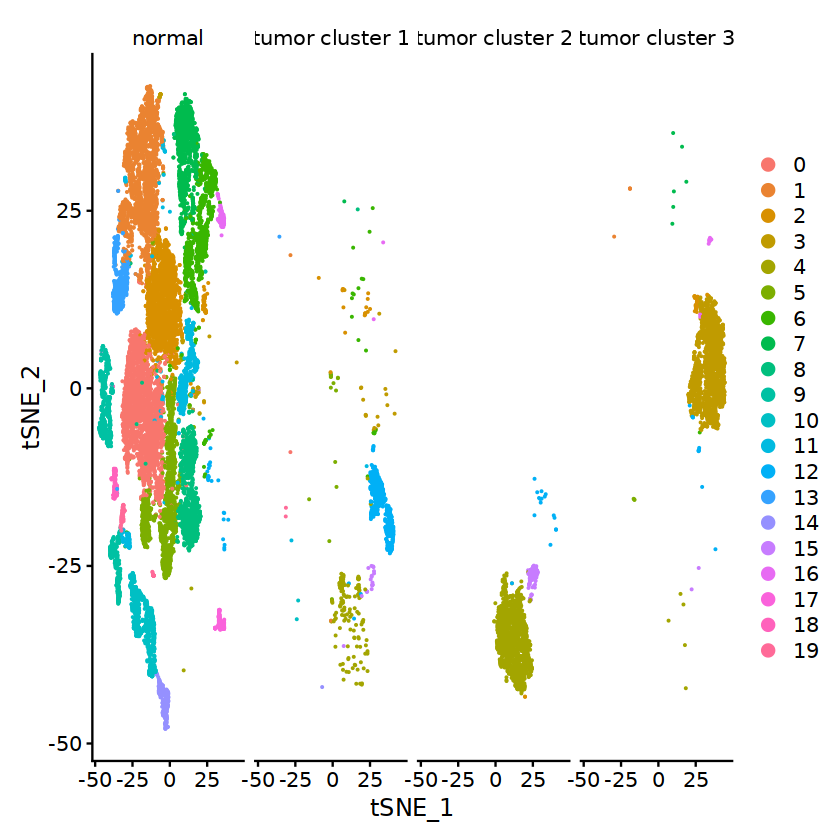

In [49]:
DimPlot(tissue, split.by = "copykat.tumor.pred")

In [50]:
copykatres = tissue@meta.data %>%  select(copykat.tumor.pred)

In [51]:
head(copykatres,3)

,copykat.tumor.pred
,<chr>
AAACGCTCAAGCAATA-1_1,normal
AAAGGGCTCCATCAGA-1_1,normal
AAAGTCCCACGGCACT-1_1,normal


In [52]:
saveRDS(copykatres,file = 'copykatres.rds')